In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [3]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Aggregate results - Homer

In [4]:
glob.glob('./motif_calling/*motifs/knownResults.txt')

['./motif_calling/00_c57_intersection_distal_motifs/knownResults.txt',
 './motif_calling/02_aj_union_distal_motifs/knownResults.txt',
 './motif_calling/00_c57_union_distal_motifs/knownResults.txt',
 './motif_calling/02_aj_intersection_motifs/knownResults.txt',
 './motif_calling/01_balbc_intersection_motifs/knownResults.txt',
 './motif_calling/00_c57_union_motifs/knownResults.txt',
 './motif_calling/01_balbc_intersection_distal_motifs/knownResults.txt',
 './motif_calling/02_aj_intersection_distal_motifs/knownResults.txt',
 './motif_calling/01_balbc_union_motifs/knownResults.txt',
 './motif_calling/00_c57_intersection_motifs/knownResults.txt',
 './motif_calling/02_aj_union_motifs/knownResults.txt',
 './motif_calling/01_balbc_union_distal_motifs/knownResults.txt']

In [5]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_log.txt', sep='\t')

# Plot known motif results

## Plot intersection motifs

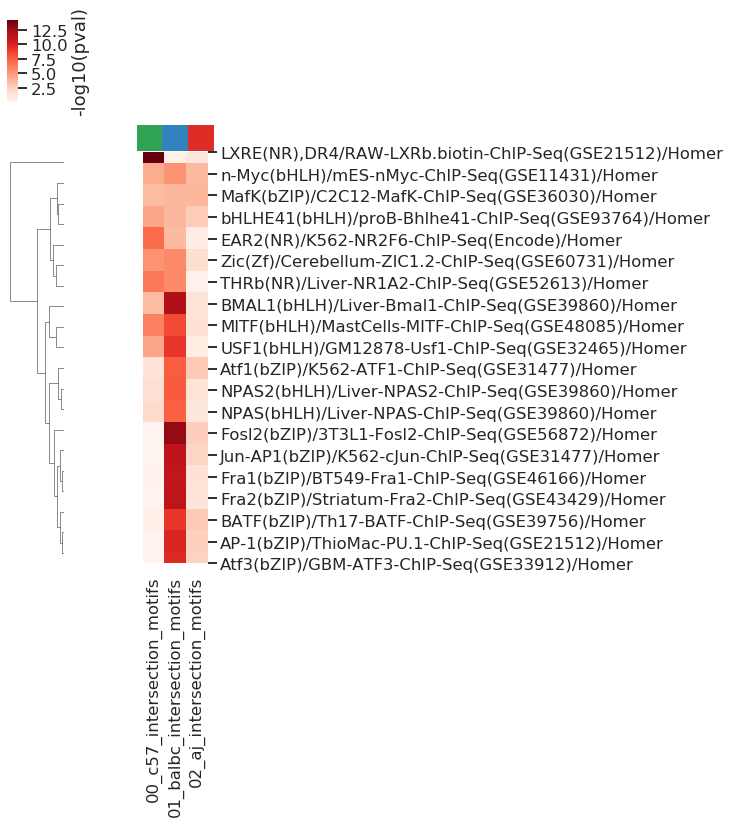

In [8]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('intersection')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

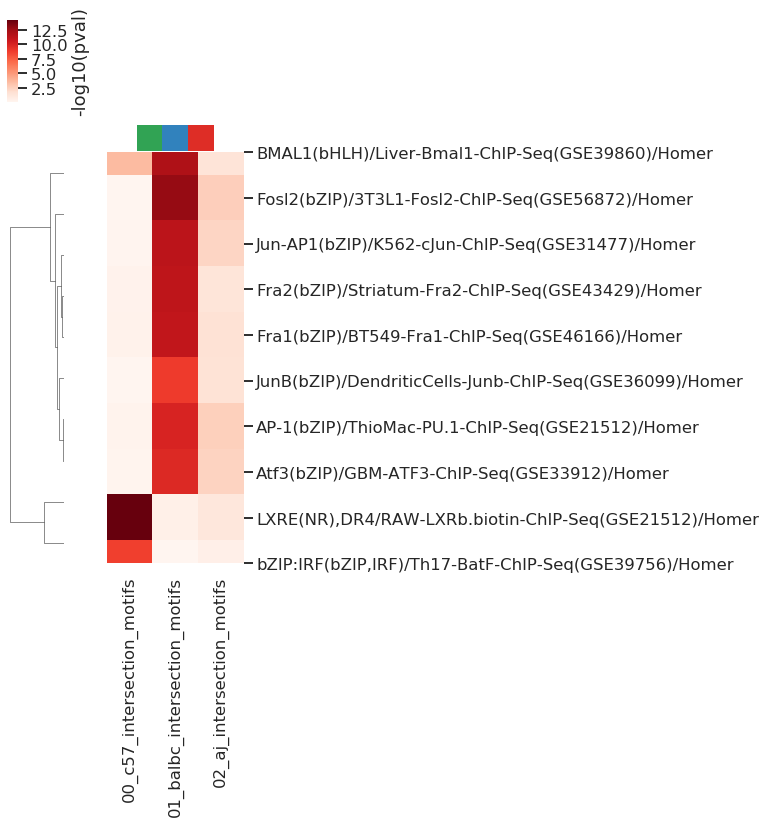

In [9]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_rankdiff_enhancers.png',
            bbox_inches='tight')

## Plot union motifs

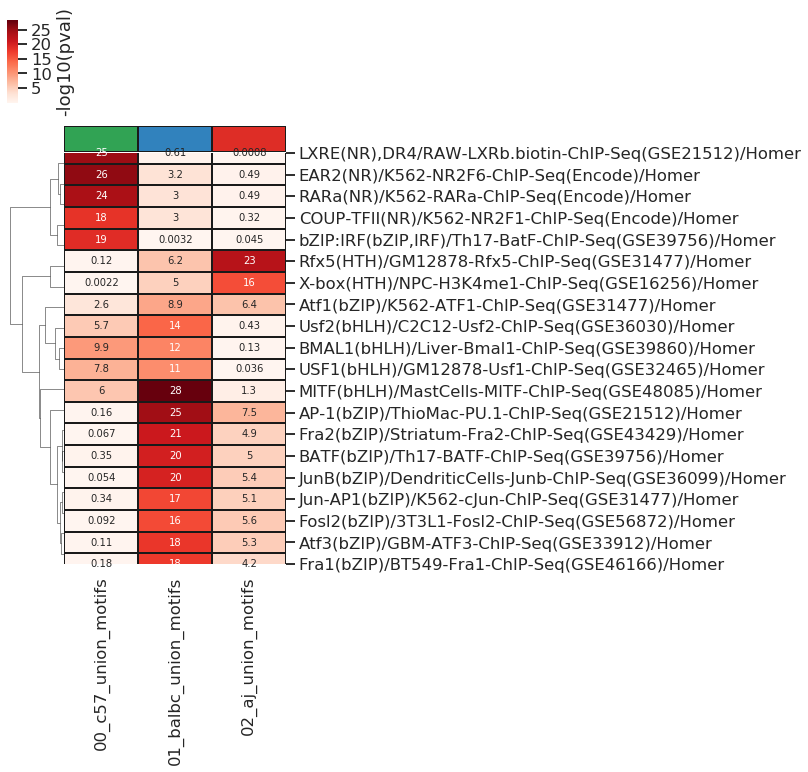

In [18]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

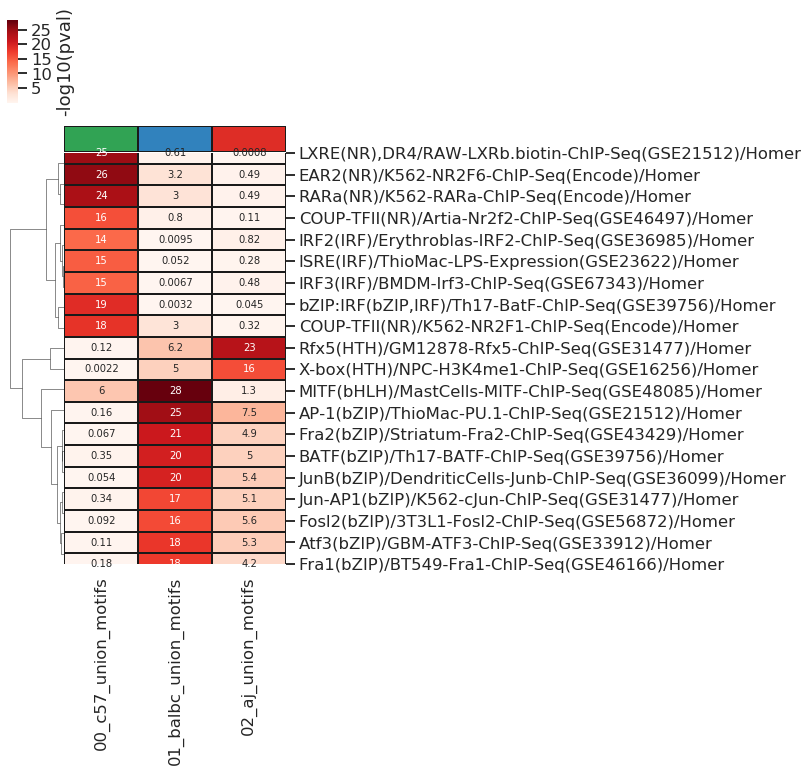

In [19]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_rankdiff_enhancers.png',
            bbox_inches='tight')

# Distal motifs

## Plot intersection distal motifs

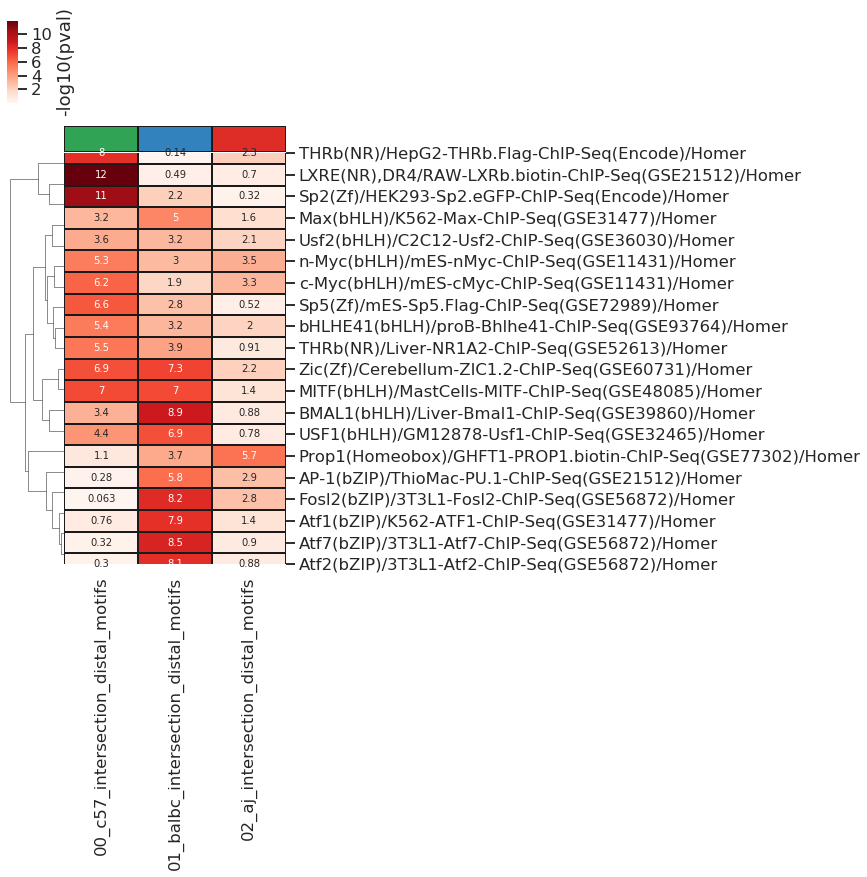

In [20]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('intersection')]
tmp_frame = tmp_frame.loc[:, tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_distal_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

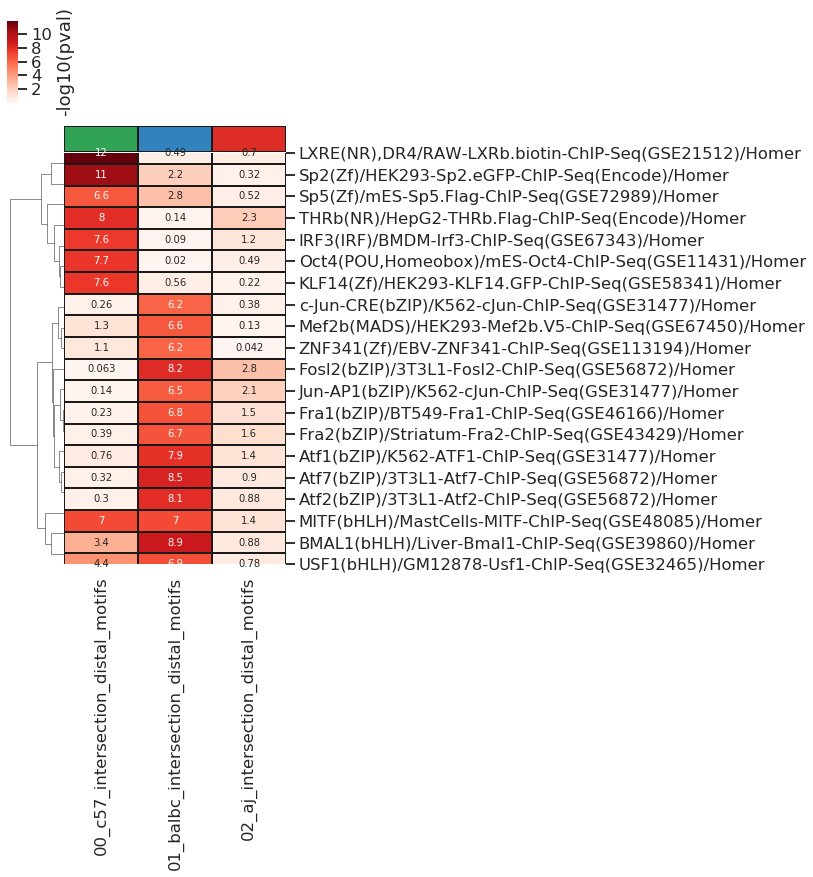

In [21]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_rankdiff_distal_enhancers.png',
            bbox_inches='tight')

## Plot union distal motifs

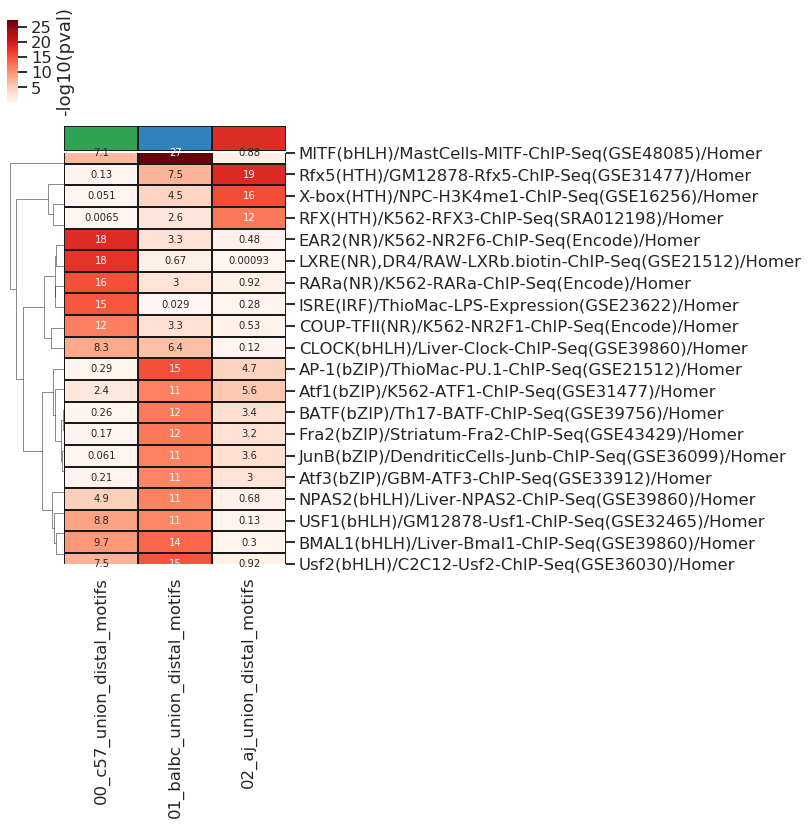

In [22]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]
tmp_frame = tmp_frame.loc[:, tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_distal_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

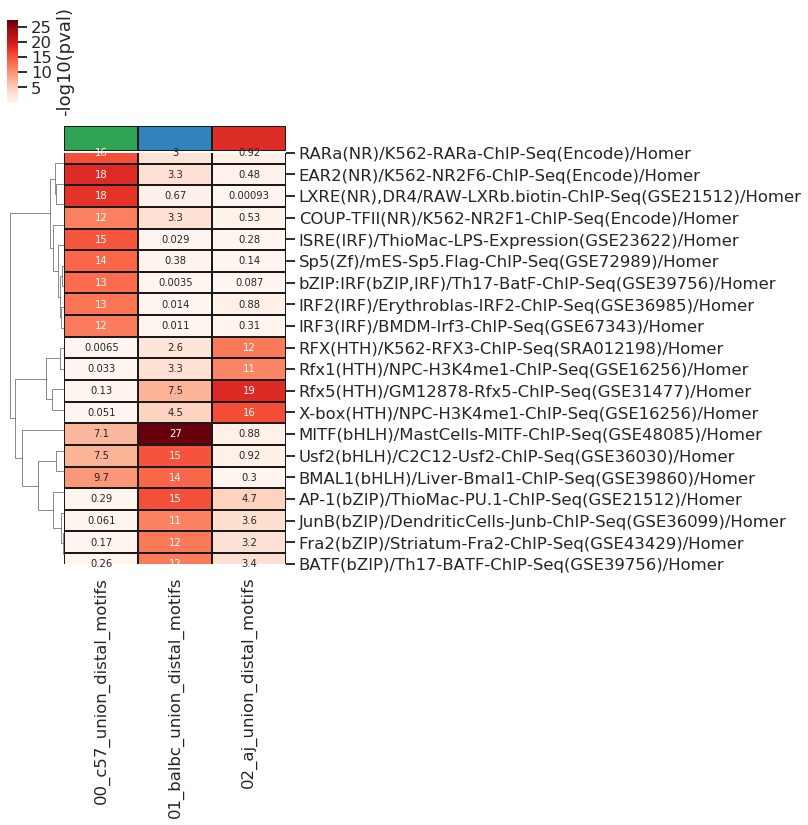

In [23]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_rankdiff_distal_enhancers.png',
            bbox_inches='tight')